In [1]:
# standard lib
import os
from pathlib import Path
from typing import Optional, Dict

# scientific libs
import numpy as np
import pandas as pd

# DL libs
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import esm
from esm.data import ESMStructuralSplitDataset
from sklearn.metrics import roc_auc_score

# graph libs
import matplotlib.pyplot as plt

#from esm_utils import *
from tqdm import tqdm

In [2]:
# precision and prediction evaluation

def compute_precisions(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(outputs, np.ndarray):
        outputs = torch.from_numpy(outputs)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if outputs.dim() == 2:
        outputs = outputs.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if outputs.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {outputs.size()}, "
            f"targets of size {targets.size()}"
        )
    device = outputs.device

    batch_size, seqlen, _ = outputs.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    
    # Check what the batch size is, comes from "batch_size, seqlen, _ = outputs.size()"
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long) 

    # check the masked_fill function in repo
    outputs = outputs.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = outputs[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(outputs).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

In [3]:
device = torch.device("cpu")
# if torch.backends.cuda.is_built():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = torch.device("mps")
print(f"Using device {device}")

Using device cpu


In [4]:
# model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.to(device)
# Freeze all parameters of the pretrained model
for param in model.parameters():
    param.requires_grad = False

# Modify only the last layer for regression task
model.contact_head.regression = nn.Linear(in_features=model.contact_head.regression.in_features, out_features=1)

# Set requires_grad=True only for the regression layer parameters to be trained
for param in model.contact_head.regression.parameters():
    param.requires_grad = True

In [5]:
# load datasets
train_dataset = ESMStructuralSplitDataset(
    split_level="superfamily", 
    cv_partition="4", 
    split="train", 
    root_path = os.path.expanduser("~/.cache/torch/data/esm"),
)

valid_dataset = ESMStructuralSplitDataset(
    split_level="superfamily", 
    cv_partition="4", 
    split="valid", 
    root_path = os.path.expanduser("~/.cache/torch/data/esm"),
)

In [6]:
# remove all the nans
masked_train = []
masked_valid = []

# modify dataset to remove/mask entries without any coordinates/distances
for t in train_dataset:
    mask = ~np.isnan(t["coords"].sum(axis=1))
    mdist = t["dist"][mask][:, mask]
    masked_entry = {
        "seq": "".join(c for c, cm in zip(t['seq'], mask) if cm),
        "ssp": "".join(c for c, cm in zip(t['ssp'], mask) if cm),
        "coords": t["coords"][mask],
        # transformed to normalised scale of 0-1, exponential decay of values up to the contact threshold distance of 15A.
        "dist": 1-np.exp(-mdist/15)
    }
    masked_train.append(masked_entry)
    
for t in valid_dataset:
    mask = ~np.isnan(t["coords"].sum(axis=1))
    mdist = t["dist"][mask][:, mask]
    masked_entry = {
        "seq": ''.join(c for c, cm in zip(t["seq"], mask) if cm),
        "ssp": ''.join(c for c, cm in zip(t["ssp"], mask) if cm),
        "coords": t["coords"][mask],
        "dist": 1-np.exp(-mdist/15)
    }
    masked_valid.append(masked_entry)

In [7]:
# Prepare data, optimizer, and objective/loss function
batch_converter = alphabet.get_batch_converter()
# new objective for IDP contacts
contact_threshold = 15

In [8]:
# generate a random example from dataset to evaluate results
rand_example = np.random.randint(len(masked_valid))
rand_target = masked_valid[rand_example]
rand_target_c = rand_target["dist"] < 15
print(f"Data point {rand_example}, {rand_target['seq']}")

Data point 1109, TATVRRAELQISDMDRGYYANHSLTLAQHPSETDERLMVRLLAFALFADDRLEFGRGLSNDDEPDLWRRDYTGDPDLWIDLGQPDESRVRKACNRSREAVVIGYGGQATETWWKKHANAMGRYRNLRVIELDSQATEALGALIQRGMRFDVIIQDGEVQMLADHGSVTLTPMVRQAPAE


In [9]:
# tokenise example and make inference/predictions
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
N = len(rand_target["seq"])
outputs = model(batch_tokens.to(device), return_contacts=True)
del batch_tokens
# create a list of the contact results
outputs_conts = []
outputs_conts.append(outputs["contacts"][0].detach().numpy())

In [10]:
outputs_conts

[array([[0.54667574, 0.5254675 , 0.5419059 , ..., 0.50750715, 0.5090615 ,
         0.50882477],
        [0.5254675 , 0.51697034, 0.5119836 , ..., 0.50622743, 0.5063913 ,
         0.5053982 ],
        [0.5419059 , 0.5119836 , 0.5192247 , ..., 0.5049027 , 0.5065671 ,
         0.5059771 ],
        ...,
        [0.50750715, 0.50622743, 0.5049027 , ..., 0.5223562 , 0.5220723 ,
         0.5494977 ],
        [0.5090615 , 0.5063913 , 0.5065671 , ..., 0.5220723 , 0.5223733 ,
         0.53412664],
        [0.50882477, 0.5053982 , 0.5059771 , ..., 0.5494977 , 0.53412664,
         0.5514779 ]], dtype=float32)]

In [11]:
rand_target["dist"]

array([[0.        , 0.3328594 , 0.3662557 , ..., 0.9250927 , 0.9480232 ,
        0.9478353 ],
       [0.3328594 , 0.        , 0.31757206, ..., 0.89085704, 0.92450964,
        0.9236841 ],
       [0.3662557 , 0.31757206, 0.        , ..., 0.90421927, 0.933732  ,
        0.9302447 ],
       ...,
       [0.9250927 , 0.89085704, 0.90421927, ..., 0.        , 0.31117845,
        0.37531722],
       [0.9480232 , 0.92450964, 0.933732  , ..., 0.31117845, 0.        ,
        0.3191902 ],
       [0.9478353 , 0.9236841 , 0.9302447 , ..., 0.37531722, 0.3191902 ,
        0.        ]], dtype=float32)

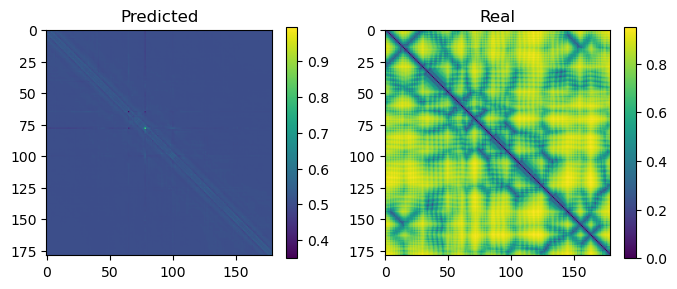

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs_conts[0])
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target["dist"])
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [13]:
# Create benchmark details on contacts ROC AUC accuracy loss, P@L

outputs_met = torch.tensor(np.array(outputs_conts[0]))
targets_met = torch.tensor(np.array(rand_target["dist"]))

example_metrics = evaluate_prediction(outputs_met, targets_met)

print(f"Metrics for: {rand_example}, {rand_target['seq']}")
for key, value in example_metrics.items():
    print(f"{key}: {value}")  
del outputs_met, targets_met

Metrics for: 1109, TATVRRAELQISDMDRGYYANHSLTLAQHPSETDERLMVRLLAFALFADDRLEFGRGLSNDDEPDLWRRDYTGDPDLWIDLGQPDESRVRKACNRSREAVVIGYGGQATETWWKKHANAMGRYRNLRVIELDSQATEALGALIQRGMRFDVIIQDGEVQMLADHGSVTLTPMVRQAPAE
local_AUC: 0.4020862579345703
local_P@L: 0.4350835680961609
local_P@L2: 0.41036632657051086
local_P@L5: 0.3747842013835907
short_AUC: 0.5729342699050903
short_P@L: 0.5952913761138916
short_P@L2: 0.5770527124404907
short_P@L5: 0.5460085868835449
medium_AUC: 0.5248203873634338
medium_P@L: 0.5933061838150024
medium_P@L2: 0.5367676615715027
medium_P@L5: 0.4380987584590912
long_AUC: 0.5939317941665649
long_P@L: 0.6145965456962585
long_P@L2: 0.5899062156677246
long_P@L5: 0.5741567611694336


In [14]:
# initialise df row list
data_rows = []

# Populate list with AUC & precision metrics for the random example
for key, value in example_metrics.items():
    data_rows.append({
        "Sample": rand_example,
        "Metric": key,
        "Value": value
    })
# Create DataFrame from list
df_metrics = pd.DataFrame(data_rows)
display(df_metrics)
del data_rows, df_metrics

,Sample,Metric,Value
0,1109,local_AUC,0.402086
1,1109,local_P@L,0.435084
2,1109,local_P@L2,0.410366
3,1109,local_P@L5,0.374784
4,1109,short_AUC,0.572934
5,1109,short_P@L,0.595291
6,1109,short_P@L2,0.577053
7,1109,short_P@L5,0.546009
8,1109,medium_AUC,0.524820
9,1109,medium_P@L,0.593306


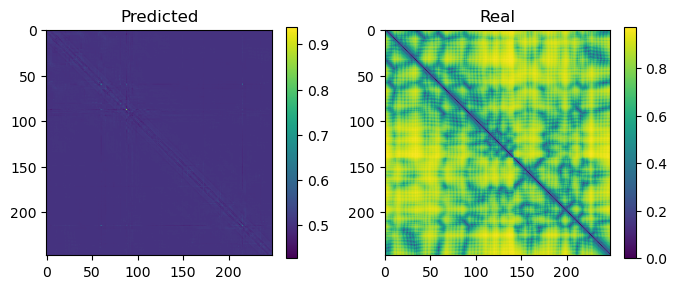

In [10]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show() # Data point 1157

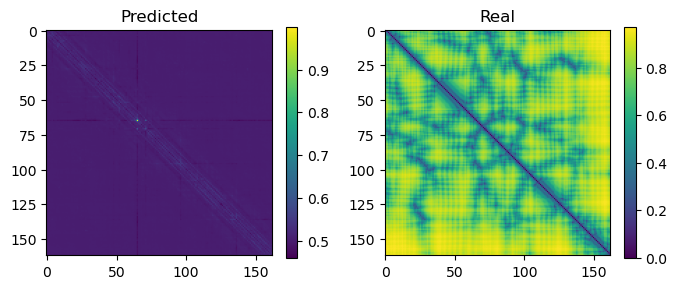

In [15]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show() # Data point 1383

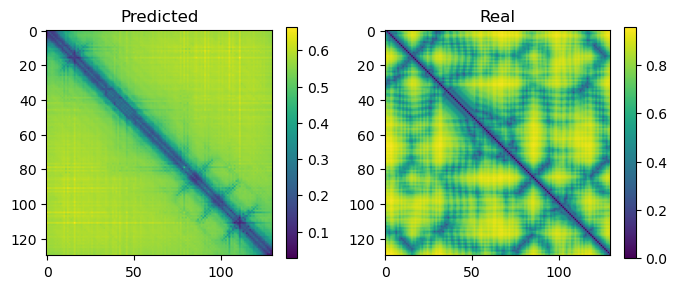

In [31]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show() # Data point 1127

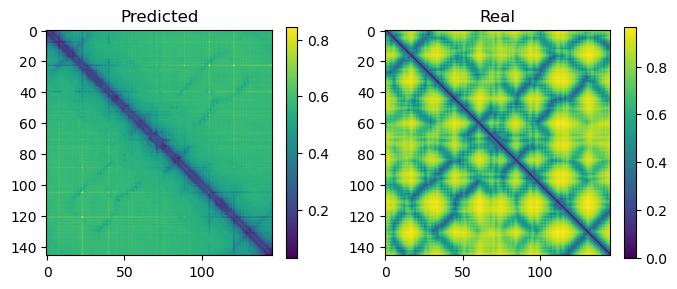

In [38]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show() # Data point 2402

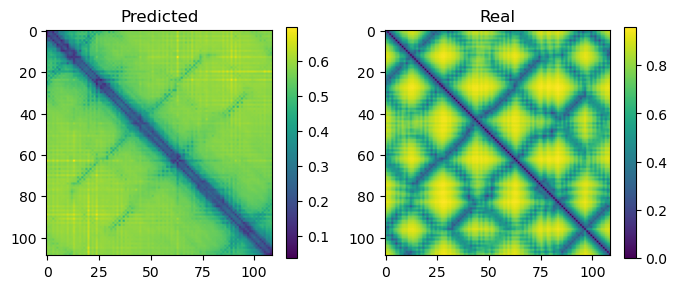

In [46]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show() # Data point 2798

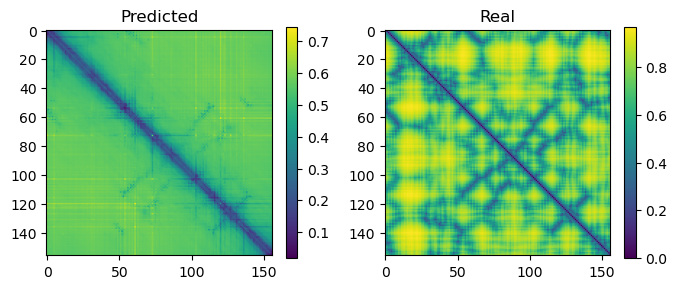

In [51]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show() # Data point 1296

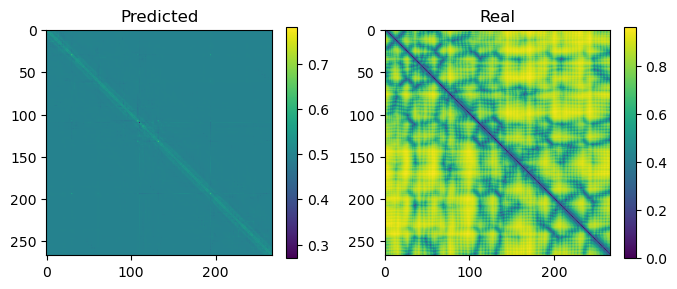

In [10]:
# Pre Data point 1413

# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

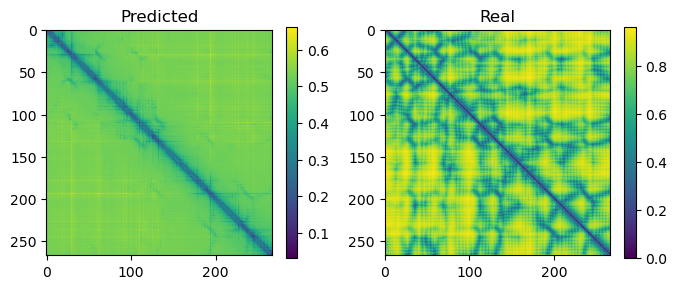

In [13]:
# Post Data point 1413

# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

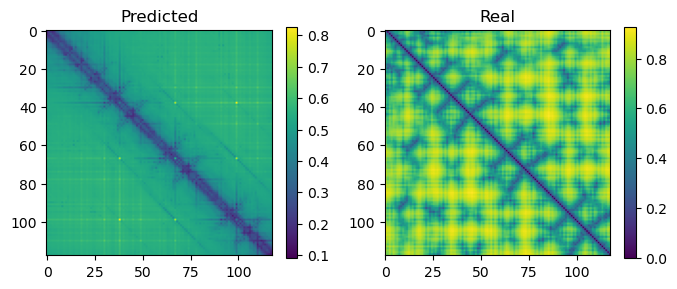

In [19]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

In [15]:
#np.random.choice(len(masked_train), size=tsize, replace=False)

array([ 1112, 12174,   664,  9295, 11261])

In [11]:
# learning_rate = 0.001
               
# # Maybe try "AdamW" with weight decay
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
               
# # Set objective function. Huber less sensitive to outliers than MSEloss, maybe try MSE as well?
# # loss calculated for each pair of input and target values
# loss_fn = nn.SmoothL1Loss(reduction='none')

# contact_threshold = 15

# # Training loop
# num_epochs = 10

# print(f"Epoch\tTrain loss\tTest loss")
# for epoch in range(num_epochs):
#     model.train()
               
#     # Initialise loss for each epoch   
#     total_loss = 0
    
# #     for b in tqdm(DataLoader(range(len(train_dataset)), batch_size=1, shuffle=True)):
#     tsize = 25
#     for b in tqdm(
#         DataLoader(np.random.choice(len(masked_train), size=tsize, replace=False), batch_size=5, shuffle=True),
#     ncols=40):
#         batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_train[i]["seq"]) for i in b])
#         # Clear gradients for each epoch
#         optimizer.zero_grad()
#         # Output predictions for batch 
#         outputs = model(batch_tokens.to(device), return_contacts=True)
#         # Is this to set the shape of the tensors?
#         targets = torch.zeros_like(outputs['contacts'])
#         mask = torch.zeros_like(outputs['contacts'])
#         for i_, ti in enumerate(b):
#             dm = masked_train[ti]['dist']
#             N = dm.shape[0]
#             targets[i_, :N, :N] = torch.tensor(dm)
#             mask[i_, :N, :N] = 1
#         # Calculates Huber loss between predictions and true values
#         loss = loss_fn(outputs['contacts'], targets)
#         loss = (loss * mask).mean()
#         # Pool loss values from each batch
#         total_loss += loss.item()
#         # Backpropagation
#         loss.backward()
#         # Updates last layer parameters to reduce loss
#         optimizer.step()
#         del batch_tokens, targets, mask
    
#     valid_loss = 0
#     vsize = 1
#     for b in DataLoader(range(vsize), batch_size=1, shuffle=True):
#         batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_valid[i]["seq"]) for i in b])
#         # Sequence inputs - IndexError: too many indices for tensor of dimension 2
#         inputs = batch_tokens
#         # contacts
#         targets = torch.tensor(np.array([masked_valid[i]['dist'] for i in b]), dtype=torch.float32)
#         outputs = model(batch_tokens.to(device), return_contacts=True)
#         # Calculates Huber loss between predictions and true values
#         loss = nn.SmoothL1Loss()(outputs['contacts'], targets)
#         # Pool loss values from each batch
#         valid_loss += loss.item()
#         del batch_tokens, targets
#     # Print loss per batch for the epoch 
# #     average_loss = total_loss / len(train_dataloader)
#     average_loss = total_loss / tsize
#     average_loss_test = valid_loss / vsize
    
#     batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
#     outputs = model(batch_tokens.to(device), return_contacts=True)
#     del batch_tokens
#     outputs_conts.append(outputs['contacts'][0].detach().numpy())
    
#     print(f"{epoch+1}/{num_epochs}\t{average_loss:.4f}\t{average_loss_test:.4f}")

Epoch	Train loss	Test loss


100%|█████| 5/5 [01:20<00:00, 16.18s/it]


1/10	0.0039	0.0295


100%|█████| 5/5 [01:00<00:00, 12.10s/it]


2/10	0.0041	0.0287


100%|█████| 5/5 [01:28<00:00, 17.74s/it]


3/10	0.0036	0.0279


100%|█████| 5/5 [01:53<00:00, 22.62s/it]


4/10	0.0039	0.0272


100%|█████| 5/5 [01:01<00:00, 12.34s/it]


5/10	0.0038	0.0265


100%|█████| 5/5 [01:34<00:00, 18.85s/it]


6/10	0.0041	0.0259


100%|█████| 5/5 [01:33<00:00, 18.80s/it]


7/10	0.0035	0.0254


100%|█████| 5/5 [01:13<00:00, 14.76s/it]


8/10	0.0029	0.0250


100%|█████| 5/5 [01:14<00:00, 14.94s/it]


9/10	0.0037	0.0246


100%|█████| 5/5 [01:44<00:00, 20.87s/it]


10/10	0.0033	0.0242


In [16]:
# learning_rate = 0.001
               
# # Maybe try "AdamW" with weight decay
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
               
# # Set objective function. Huber less sensitive to outliers than MSEloss, maybe try MSE as well?
# # loss calculated for each pair of input and target values
# loss_fn = nn.SmoothL1Loss(reduction='none')

# contact_threshold = 15

# # Training loop
# num_epochs = 10

# print(f"Epoch\tTrain loss\tTest loss")
# for epoch in range(num_epochs):
#     model.train()
               
#     # Initialise loss for each epoch   
#     total_loss = 0
    
# #     for b in tqdm(DataLoader(range(len(train_dataset)), batch_size=1, shuffle=True)):
#     tsize = 40
#     for b in tqdm(
#         DataLoader(np.random.choice(len(masked_train), size=tsize, replace=False), batch_size=5, shuffle=True),
#     ncols=40):
#         batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_train[i]["seq"]) for i in b])
#         # Clear gradients for each epoch
#         optimizer.zero_grad()
#         # Output predictions for batch 
#         outputs = model(batch_tokens.to(device), return_contacts=True)
#         # Is this to set the shape of the tensors?
#         targets = torch.zeros_like(outputs['contacts'])
#         mask = torch.zeros_like(outputs['contacts'])
#         for i_, ti in enumerate(b):
#             dm = masked_train[ti]['dist']
#             N = dm.shape[0]
#             targets[i_, :N, :N] = torch.tensor(dm)
#             mask[i_, :N, :N] = 1
#         # Calculates Huber loss between predictions and true values
#         loss = loss_fn(outputs['contacts'], targets)
#         loss = (loss * mask).mean()
#         # Pool loss values from each batch
#         total_loss += loss.item()
#         # Backpropagation
#         loss.backward()
#         # Updates last layer parameters to reduce loss
#         optimizer.step()
#         del batch_tokens, targets, mask
    
#     valid_loss = 0
#     vsize = 1
#     for b in DataLoader(range(vsize), batch_size=1, shuffle=True):
#         batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_valid[i]["seq"]) for i in b])
#         # Sequence inputs - IndexError: too many indices for tensor of dimension 2
#         inputs = batch_tokens
#         # contacts
#         targets = torch.tensor(np.array([masked_valid[i]['dist'] for i in b]), dtype=torch.float32)
#         outputs = model(batch_tokens.to(device), return_contacts=True)
#         # Calculates Huber loss between predictions and true values
#         loss = nn.SmoothL1Loss()(outputs['contacts'], targets)
#         # Pool loss values from each batch
#         valid_loss += loss.item()
#         del batch_tokens, targets
#     # Print loss per batch for the epoch 
# #     average_loss = total_loss / len(train_dataloader)
#     average_loss = total_loss / tsize
#     average_loss_test = valid_loss / vsize
    
#     batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
#     outputs = model(batch_tokens.to(device), return_contacts=True)
#     del batch_tokens
#     outputs_conts.append(outputs['contacts'][0].detach().numpy())
    
#     print(f"{epoch+1}/{num_epochs}\t{average_loss:.4f}\t{average_loss_test:.4f}")

Epoch	Train loss	Test loss


100%|█████| 8/8 [03:37<00:00, 27.21s/it]


1/10	0.0047	0.0289


100%|█████| 8/8 [04:16<00:00, 32.12s/it]


2/10	0.0035	0.0276


100%|█████| 8/8 [02:59<00:00, 22.47s/it]


3/10	0.0041	0.0265


100%|█████| 8/8 [02:23<00:00, 17.92s/it]


4/10	0.0037	0.0255


100%|█████| 8/8 [02:29<00:00, 18.65s/it]


5/10	0.0038	0.0247


100%|█████| 8/8 [02:40<00:00, 20.09s/it]


6/10	0.0033	0.0240


100%|█████| 8/8 [02:03<00:00, 15.46s/it]


7/10	0.0035	0.0235


100%|█████| 8/8 [01:59<00:00, 14.88s/it]


8/10	0.0040	0.0229


100%|█████| 8/8 [02:38<00:00, 19.84s/it]


9/10	0.0029	0.0224


100%|█████| 8/8 [02:19<00:00, 17.39s/it]


10/10	0.0033	0.0220


# Final training test

In [15]:
# Training loop
learning_rate = 0.001

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
               
# loss is calculated for each input and target pair, mean values calculated manually
loss_fn = nn.SmoothL1Loss(reduction="none")

num_epochs = 10

print(f"Epoch\tTrain loss\tTest loss")
for epoch in range(num_epochs):
    model.train()
               
    # Initialise loss for each epoch   
    total_loss = 0
    # Number of sequences used to train model (80/12312 samples)
    tsize = 80
    # Training on randomly selected sequences in batches of 10
    for b in tqdm(
        DataLoader(np.random.choice(len(masked_train), size=tsize, replace=False), batch_size=8, shuffle=True),
    ncols=40):
        # Tokenise input sequences
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_train[i]["seq"]) for i in b])
        # Clear gradients for each epoch
        optimizer.zero_grad()
        # Output predictions for batch 
        outputs = model(batch_tokens.to(device), return_contacts=True)
        # Initialise objects to 0 to match the format of contact output tensor
        targets = torch.zeros_like(outputs["contacts"])
        mask = torch.zeros_like(outputs["contacts"])
        
        # Pull masked and threshold normalised distance values from sequences trained on 
        for i_, ti in enumerate(b):
            dm = masked_train[ti]["dist"]
            N = dm.shape[0]
            targets[i_, :N, :N] = torch.tensor(dm)
            mask[i_, :N, :N] = 1
            
        # Calculates smooth L1 loss between predictions and true values
        loss = loss_fn(outputs["contacts"], targets)
        # Manually calculate mean per run (reduction = "none")
        loss = (loss * mask).mean()
        # Pool loss values from each batch
        total_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Updates last layer parameters to reduce loss
        optimizer.step()
        del batch_tokens, targets, mask
    
    valid_loss = 0
    vsize = 1
    for b in DataLoader(range(vsize), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_valid[i]["seq"]) for i in b])
        inputs = batch_tokens
        # contacts
        targets = torch.tensor(np.array([masked_valid[i]["dist"] for i in b]), dtype=torch.float32)
        outputs = model(batch_tokens.to(device), return_contacts=True)
        # Calculates Huber loss between predictions and true values
        loss = nn.SmoothL1Loss()(outputs["contacts"], targets)
        # Pool loss values from each batch
        valid_loss += loss.item()
        del batch_tokens, targets
    # Print loss per epoch 
    average_loss = total_loss / tsize
    average_loss_test = valid_loss / vsize
    
    # Print AUC per epoch
    #auc_score = roc_auc_score(targets, outputs)
    
    # # For animated gif example
    # batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
    # outputs = model(batch_tokens.to(device), return_contacts=True)
    # del batch_tokens
    # outputs_conts.append(outputs["contacts"][0].detach().numpy())
    
    print(f"{epoch+1}/{num_epochs}\t{average_loss:.4f}\t{average_loss_test:.4f}")
    #print("AUC Score:", auc_score)

Epoch	Train loss	Test loss


100%|███| 10/10 [11:07<00:00, 66.77s/it]


1/10	0.0019	0.0284


100%|███| 10/10 [05:05<00:00, 30.54s/it]


2/10	0.0021	0.0268


100%|███| 10/10 [06:28<00:00, 38.82s/it]


3/10	0.0020	0.0254


100%|███| 10/10 [05:28<00:00, 32.90s/it]


4/10	0.0016	0.0244


100%|███| 10/10 [06:30<00:00, 39.02s/it]


5/10	0.0019	0.0236


100%|███| 10/10 [09:42<00:00, 58.26s/it]


6/10	0.0015	0.0229


100%|███| 10/10 [04:31<00:00, 27.17s/it]


7/10	0.0020	0.0223


100%|███| 10/10 [03:53<00:00, 23.39s/it]


8/10	0.0017	0.0216


100%|███| 10/10 [06:36<00:00, 39.63s/it]


9/10	0.0016	0.0211


100%|███| 10/10 [05:05<00:00, 30.58s/it]


10/10	0.0016	0.0206


Epoch	Train loss	Test loss


100%|█████| 5/5 [06:01<00:00, 72.40s/it]


1/10	0.0018	0.0308


100%|█████| 5/5 [03:06<00:00, 37.29s/it]


2/10	0.0017	0.0299


100%|█████| 5/5 [04:50<00:00, 58.15s/it]


3/10	0.0015	0.0290


100%|█████| 5/5 [04:49<00:00, 57.96s/it]


4/10	0.0015	0.0283


100%|█████| 5/5 [04:49<00:00, 57.97s/it]


5/10	0.0013	0.0276


100%|█████| 5/5 [04:10<00:00, 50.14s/it]


6/10	0.0013	0.0271


100%|█████| 5/5 [03:28<00:00, 41.77s/it]


7/10	0.0015	0.0265


100%|█████| 5/5 [03:15<00:00, 39.15s/it]


8/10	0.0016	0.0260


100%|█████| 5/5 [03:40<00:00, 44.10s/it]


9/10	0.0014	0.0255


100%|█████| 5/5 [04:58<00:00, 59.68s/it]


10/10	0.0014	0.0250


# Same example after tuning

In [16]:
# Run again for a new set of predictions with trained model
model.eval()
# tokenise example and make inference/predictions
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
N = len(rand_target["seq"])
outputs = model(batch_tokens.to(device), return_contacts=True)
del batch_tokens
# create a list of the contact results
outputs_conts = []
outputs_conts.append(outputs["contacts"][0].detach().numpy())

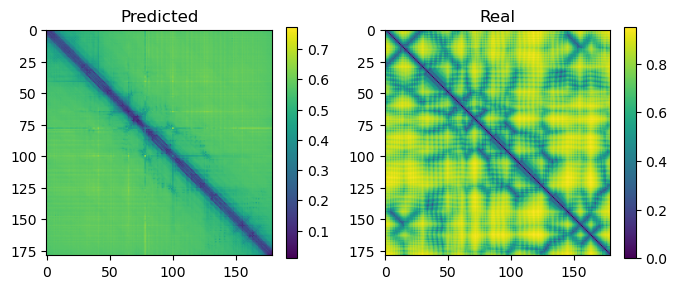

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs_conts[0])
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target["dist"])
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [33]:
outputs_met = torch.tensor(np.array(outputs_conts[0]))
targets_met = torch.tensor(np.array(rand_target["dist"]))

example_metrics = evaluate_prediction(outputs_met, targets_met)

print(f"Metrics for: {rand_example}, {rand_target['seq']}")
for key, value in example_metrics.items():
    print(f"{key}: {value}")

Metrics for: 1109, TATVRRAELQISDMDRGYYANHSLTLAQHPSETDERLMVRLLAFALFADDRLEFGRGLSNDDEPDLWRRDYTGDPDLWIDLGQPDESRVRKACNRSREAVVIGYGGQATETWWKKHANAMGRYRNLRVIELDSQATEALGALIQRGMRFDVIIQDGEVQMLADHGSVTLTPMVRQAPAE
local_AUC: 0.5783817768096924
local_P@L: 0.5523018836975098
local_P@L2: 0.5756933093070984
local_P@L5: 0.604124903678894
short_AUC: 0.753630518913269
short_P@L: 0.7235075235366821
short_P@L2: 0.7486083507537842
short_P@L5: 0.7833864092826843
medium_AUC: 0.6928481459617615
medium_P@L: 0.7095891833305359
medium_P@L2: 0.6914389133453369
medium_P@L5: 0.679216742515564
long_AUC: 0.6894728541374207
long_P@L: 0.6978464126586914
long_P@L2: 0.6841509938240051
long_P@L5: 0.6915801167488098


In [19]:
# initialise df row list
data_rows = []

# Populate list with AUC & precision metrics for the random example
for key, value in example_metrics.items():
    data_rows.append({
        "Sample": rand_example,
        "Metric": key,
        "Value": value
    })
# Create DataFrame from list
df_metrics = pd.DataFrame(data_rows)
display(df_metrics)

,Sample,Metric,Value
0,1109,local_AUC,0.578382
1,1109,local_P@L,0.552302
2,1109,local_P@L2,0.575693
3,1109,local_P@L5,0.604125
4,1109,short_AUC,0.753631
5,1109,short_P@L,0.723508
6,1109,short_P@L2,0.748608
7,1109,short_P@L5,0.783386
8,1109,medium_AUC,0.692848
9,1109,medium_P@L,0.709589


In [44]:
from typing import Union, Callable
import matplotlib as mpl

def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:
    
    predictions = predictions >= 0.5
    contacts = contacts >= 0.5

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

In [41]:
outputs_met.shape

torch.Size([179, 179])

In [42]:
targets_met.shape

torch.Size([179, 179])

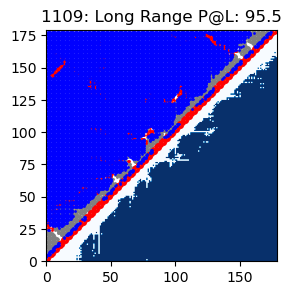

In [53]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=1)
prediction = outputs_met
target = targets_met
plot_contacts_and_predictions(prediction, target, title = lambda prec: f"{rand_example}: Long Range P@L: {100 * prec:0.1f}")
plt.show()

In [26]:
# Save the fine tuned model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'trained_model_aw.pth')

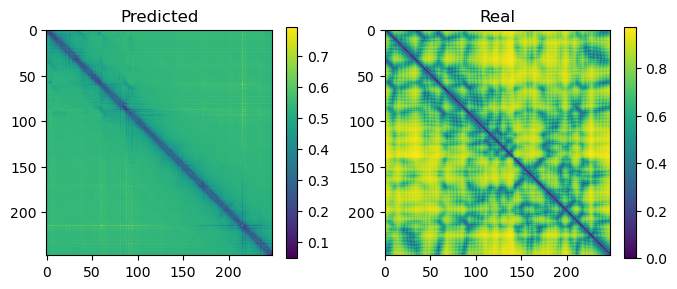

In [12]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

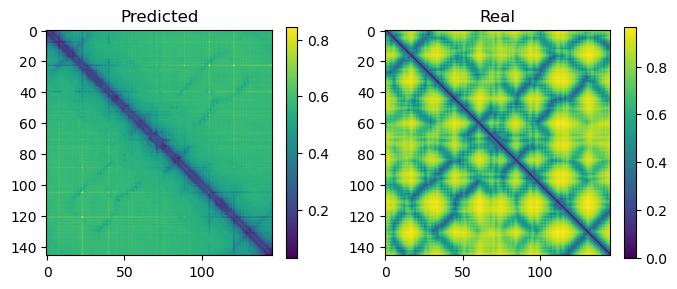

In [39]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs_conts[-1])
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'])
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

# Animated example

In [40]:
import matplotlib.animation as animation
from IPython.display import HTML

In [53]:
%%capture
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
im = ax[0].imshow(outputs_conts[0])#, vmin=0, vmax=1)
# fig.colorbar(im)
ax[0].set_title("Predicted")
im2 = ax[1].imshow(rand_target['dist'], vmin=0, vmax=1)
fig.colorbar(im2)#, ax=ax)
ax[1].set_title("Real")
fig.tight_layout()

def update(frame):
    # update the line plot:
    im.set_data(outputs_conts[frame])
    return im

# 5s gif
total_time = 5000
interval = total_time // len(outputs_conts)
print(f"Interval of {interval} ms.")
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(outputs_conts), interval=interval)
# ani.save(filename="learn.gif", writer="pillow")

In [54]:
print(f"Interval of {interval} ms.")

Interval of 5000 ms.


In [55]:
HTML(ani.to_jshtml())